In [61]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [63]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.backend import clear_session
from tensorflow.random import set_seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Lambda, LSTM, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import LearningRateScheduler, History
from tensorflow.keras.metrics import mean_absolute_error
# 设置显存自动增长
physical_devices = tf.config.list_physical_devices('GPU')
for physical_device in physical_devices:
    tf.config.experimental.set_memory_growth(physical_device, enable=True)
print(tf.__version__)

2.3.0


In [64]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [65]:
def windowed_dataset(series: np.ndarray, window_size: int, batch_size: int, shuffle_buffer: int) -> tf.raw_ops.PrefetchDataset:
    dataset: tf.raw_ops.TensorSliceDataset = tf.data.Dataset.from_tensor_slices(series)
    dataset: tf.raw_ops.WindowDataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset: tf.raw_ops.FlatMapDataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset: tf.raw_ops.MapDataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset: tf.raw_ops.PrefetchDataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [66]:
clear_session()
set_seed(51)
np.random.seed(51)

clear_session()
dataset: tf.raw_ops.PrefetchDataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential([
    Lambda(function=lambda x: tf.expand_dims(x, axis=-1), name="lambda_1", input_shape=[None]),
    Bidirectional(LSTM(units=32, return_sequences=True), name="LSTM_1"),
    Bidirectional(LSTM(units=32, return_sequences=False), name="LSTM_2"),
    Dense(units=1, name="dense_3"),
    Lambda(function=lambda x: x * 100.0, name="lambda_3")
])

model.compile(
    loss=Huber(),
    optimizer=SGD(lr=1e-8, momentum=0.9),
    metrics=["mae"]
)

history: History = model.fit(
    dataset, 
    epochs=100, 
    workers=-1,
    use_multiprocessing=True,
    callbacks=[
        LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
    ]
)

Epoch 1/100
31/31 [==============================] - 0s 8ms/step - loss: 21.5167 - mae: 22.0115
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 21.1522 - mae: 21.6444
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 20.7302 - mae: 21.2236
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 20.2834 - mae: 20.7757
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 19.7897 - mae: 20.2855
Epoch 6/100
31/31 [==============================] - 0s 7ms/step - loss: 19.1782 - mae: 19.6696
Epoch 7/100
31/31 [==============================] - 0s 7ms/step - loss: 18.2410 - mae: 18.7333
Epoch 8/100
31/31 [==============================] - 0s 7ms/step - loss: 17.4825 - mae: 17.9748
Epoch 9/100
31/31 [==============================] - 0s 7ms/step - loss: 17.1597 - mae: 17.6529
Epoch 10/100
31/31 [==============================] - 0s 7ms/step - loss: 16.8547 - mae: 17.3463
Epoch 11/100
31/31 [===================

ERROR: Could not find a version that satisfies the requirement tf-nightly-2.0-preview (from versions: none)
ERROR: No matching distribution found for tf-nightly-2.0-preview
You should consider upgrading via the 'c:\users\drzon\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


31/31 [==============================] - 0s 7ms/step - loss: 15.0752 - mae: 15.5697
Epoch 17/100
31/31 [==============================] - 0s 7ms/step - loss: 14.7905 - mae: 15.2869
Epoch 18/100
31/31 [==============================] - 0s 7ms/step - loss: 14.5229 - mae: 15.0178
Epoch 19/100
31/31 [==============================] - 0s 7ms/step - loss: 14.2707 - mae: 14.7636
Epoch 20/100
31/31 [==============================] - 0s 7ms/step - loss: 14.0293 - mae: 14.5217
Epoch 21/100
31/31 [==============================] - 0s 7ms/step - loss: 13.8191 - mae: 14.3135
Epoch 22/100
31/31 [==============================] - 0s 7ms/step - loss: 13.6084 - mae: 14.1032
Epoch 23/100
31/31 [==============================] - 0s 7ms/step - loss: 13.4096 - mae: 13.9038
Epoch 24/100
31/31 [==============================] - 0s 7ms/step - loss: 13.1859 - mae: 13.6794
Epoch 25/100
31/31 [==============================] - 0s 7ms/step - loss: 12.9819 - mae: 13.4747
Epoch 26/100
31/31 [=======================

(1e-08, 0.0001, 0.0, 30.0)

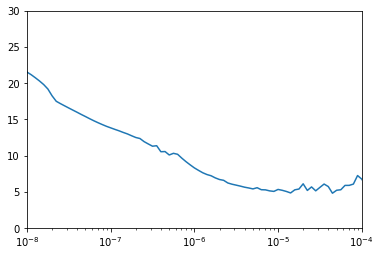

In [67]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [68]:
clear_session()
set_seed(51)
np.random.seed(51)

clear_session()
dataset: tf.raw_ops.PrefetchDataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential([
    Lambda(function=lambda x: tf.expand_dims(x, axis=-1), name="lambda_1", input_shape=[None]),
    Bidirectional(LSTM(units=32, return_sequences=True), name="LSTM_1"),
    Bidirectional(LSTM(units=32, return_sequences=False), name="LSTM_2"),
    Dense(units=1, name="dense_3"),
    Lambda(function=lambda x: x * 100.0, name="lambda_3")
])


model.compile(
    loss="mse", 
    optimizer=SGD(lr=1e-5, momentum=0.9),
    metrics=["mae"]
)
history: History = model.fit(
    dataset,
    epochs=500,
    workers=-1,
    use_multiprocessing=True
)

Epoch 1/500
31/31 [==============================] - 0s 8ms/step - loss: 775.0154 - mae: 21.4039
Epoch 2/500
31/31 [==============================] - 0s 7ms/step - loss: 122.4954 - mae: 8.3698
Epoch 3/500
31/31 [==============================] - 0s 7ms/step - loss: 114.6226 - mae: 8.3867
Epoch 4/500
31/31 [==============================] - 0s 7ms/step - loss: 123.7882 - mae: 8.8450
Epoch 5/500
31/31 [==============================] - 0s 7ms/step - loss: 118.7426 - mae: 8.6543
Epoch 6/500
31/31 [==============================] - 0s 7ms/step - loss: 111.2691 - mae: 8.2232
Epoch 7/500
31/31 [==============================] - 0s 7ms/step - loss: 77.0797 - mae: 6.8055
Epoch 8/500
31/31 [==============================] - 0s 7ms/step - loss: 69.2532 - mae: 6.4012
Epoch 9/500
31/31 [==============================] - 0s 7ms/step - loss: 62.4633 - mae: 6.0448
Epoch 10/500
31/31 [==============================] - 0s 7ms/step - loss: 75.3051 - mae: 6.8217
Epoch 11/500
31/31 [======================

31/31 [==============================] - 0s 7ms/step - loss: 42.5849 - mae: 4.9991
Epoch 171/500
31/31 [==============================] - 0s 7ms/step - loss: 39.7259 - mae: 4.7819
Epoch 172/500
31/31 [==============================] - 0s 7ms/step - loss: 46.4762 - mae: 5.1438
Epoch 173/500
31/31 [==============================] - 0s 7ms/step - loss: 41.4601 - mae: 4.8835
Epoch 174/500
31/31 [==============================] - 0s 7ms/step - loss: 46.8787 - mae: 5.2158
Epoch 175/500
31/31 [==============================] - 0s 7ms/step - loss: 39.5866 - mae: 4.7482
Epoch 176/500
31/31 [==============================] - 0s 7ms/step - loss: 41.2514 - mae: 4.9206
Epoch 177/500
31/31 [==============================] - 0s 7ms/step - loss: 41.5678 - mae: 4.9136
Epoch 178/500
31/31 [==============================] - 0s 7ms/step - loss: 39.4284 - mae: 4.7508
Epoch 179/500
31/31 [==============================] - 0s 7ms/step - loss: 48.0517 - mae: 5.3321
Epoch 180/500
31/31 [=======================

31/31 [==============================] - 0s 7ms/step - loss: 39.7720 - mae: 4.7724
Epoch 339/500
31/31 [==============================] - 0s 7ms/step - loss: 39.8229 - mae: 4.8169
Epoch 340/500
31/31 [==============================] - 0s 7ms/step - loss: 39.7849 - mae: 4.8091
Epoch 341/500
31/31 [==============================] - 0s 7ms/step - loss: 40.9400 - mae: 4.8858
Epoch 342/500
31/31 [==============================] - 0s 7ms/step - loss: 45.4259 - mae: 5.1662
Epoch 343/500
31/31 [==============================] - 0s 7ms/step - loss: 40.6229 - mae: 4.8688
Epoch 344/500
31/31 [==============================] - 0s 7ms/step - loss: 37.3387 - mae: 4.6439
Epoch 345/500
31/31 [==============================] - 0s 7ms/step - loss: 38.8033 - mae: 4.7767
Epoch 346/500
31/31 [==============================] - 0s 7ms/step - loss: 43.4491 - mae: 5.0561
Epoch 347/500
31/31 [==============================] - 0s 7ms/step - loss: 38.1681 - mae: 4.6594
Epoch 348/500
31/31 [=======================

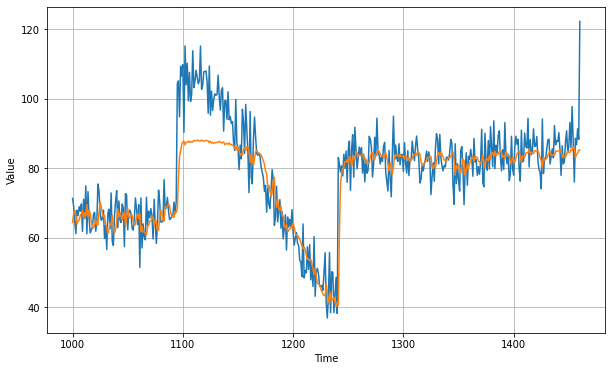

In [69]:
forecast: tf.raw_ops.TensorSliceDataset = tf.data.Dataset.from_tensor_slices(series[split_time - window_size:-1])
forecast: tf.raw_ops.WindowDataset = forecast.window(window_size, shift=1, drop_remainder=True)
forecast: tf.raw_ops.FlatMapDataset = forecast.flat_map(lambda x: x.batch(window_size))
forecast: tf.raw_ops.BatchDataset = forecast.batch(batch_size)
forecast: tf.raw_ops.PrefetchDataset = forecast.prefetch(1)


results = model.predict(forecast)[:, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [70]:
print(mean_absolute_error(x_valid, results).numpy())

5.775017


<Figure size 432x288 with 0 Axes>

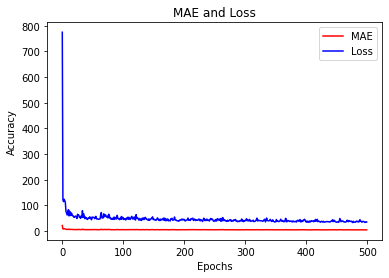

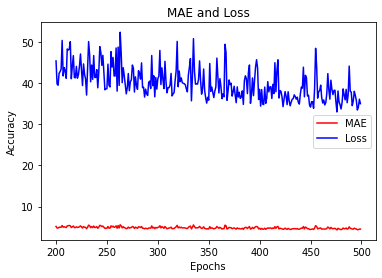

<Figure size 432x288 with 0 Axes>

In [71]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [72]:
clear_session()
dataset: tf.raw_ops.PrefetchDataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential([
    Lambda(function=lambda x: tf.expand_dims(x, axis=-1), name="lambda_1", input_shape=[None]),
    Bidirectional(LSTM(units=32, return_sequences=True), name="LSTM_1"),
    Bidirectional(LSTM(units=32, return_sequences=False), name="LSTM_2"),
    Dense(units=1, name="dense_3"),
    Lambda(function=lambda x: x * 100.0, name="lambda_3")
])


model.compile(
    loss="mse", 
    optimizer=SGD(lr=1e-6, momentum=0.9)
)
model.fit(
    dataset,
    epochs=100, 
    workers=-1,
    use_multiprocessing=True
)

Epoch 1/100
31/31 [==============================] - 0s 7ms/step - loss: 739.1971
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 108.6536
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 74.2263
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 66.8335
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 63.2462
Epoch 6/100
31/31 [==============================] - 0s 7ms/step - loss: 60.6564
Epoch 7/100
31/31 [==============================] - 0s 7ms/step - loss: 57.7060
Epoch 8/100
31/31 [==============================] - 0s 7ms/step - loss: 60.1065
Epoch 9/100
31/31 [==============================] - 0s 7ms/step - loss: 50.8930
Epoch 10/100
31/31 [==============================] - 0s 7ms/step - loss: 50.2056
Epoch 11/100
31/31 [==============================] - 0s 7ms/step - loss: 51.2971
Epoch 12/100
31/31 [==============================] - 0s 7ms/step - loss: 53.6144
Epoch 13/100
31/31 [===

In [73]:
clear_session()
dataset: tf.raw_ops.PrefetchDataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential([
    Lambda(function=lambda x: tf.expand_dims(x, axis=-1), name="lambda_1", input_shape=[None]),
    Bidirectional(LSTM(units=32, return_sequences=True), name="LSTM_1"),
    Bidirectional(LSTM(units=32, return_sequences=True), name="LSTM_2"),
    Bidirectional(LSTM(units=32, return_sequences=False), name="LSTM_3"),
    Dense(units=1, name="dense_4"),
    Lambda(function=lambda x: x * 100.0, name="lambda_4")
])


model.compile(
    loss="mse", 
    optimizer=SGD(lr=1e-6, momentum=0.9)
)

model.fit(
    dataset,
    epochs=100,
    workers=-1,
    use_multiprocessing=True
)

Epoch 1/100
31/31 [==============================] - 0s 10ms/step - loss: 755.7013
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 152.7785
Epoch 3/100
31/31 [==============================] - 0s 9ms/step - loss: 97.9761
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: 83.2915
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 78.2600
Epoch 6/100
31/31 [==============================] - 0s 9ms/step - loss: 73.4347
Epoch 7/100
31/31 [==============================] - 0s 9ms/step - loss: 67.8632
Epoch 8/100
31/31 [==============================] - 0s 9ms/step - loss: 74.5354
Epoch 9/100
31/31 [==============================] - 0s 9ms/step - loss: 73.1458
Epoch 10/100
31/31 [==============================] - 0s 9ms/step - loss: 63.4809
Epoch 11/100
31/31 [==============================] - 0s 9ms/step - loss: 60.9757
Epoch 12/100
31/31 [==============================] - 0s 9ms/step - loss: 57.7044
Epoch 13/100
31/31 [==